Finding Critical Points using RNNs

Credits:

 - idea: https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/441470
 - dataloader: https://www.kaggle.com/code/henriupton/efficient-loading-memory-usage-visualizations-cmi
 - arch: https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction/discussion/416410

# 1. Configuration

In [ ]:
import pandas as pd
import numpy as np
import gc
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import os
import joblib
import random
import math
from tqdm.auto import tqdm

from scipy.interpolate import interp1d

from math import pi, sqrt, exp
import sklearn,sklearn.model_selection
import torch
from torch import nn,Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")

from pyarrow.parquet import ParquetFile
import pyarrow as pa
import ctypes

def normalize(y):
    mean = y[:,0].mean().item()
    std = y[:,0].std().item()
    y[:,0] = (y[:,0]-mean)/(std+1e-16)
    mean = y[:,1].mean().item()
    std = y[:,1].std().item()
    y[:,1] = (y[:,1]-mean)/(std+1e-16)
    return y

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
EPOCHS = 5
WARMUP_PROP = 0.2
BS = 1
WORKERS = 4
TRAIN_PROP = 0.9
max_chunk_size = 150000
if device=='cpu':
    torch.set_num_interop_threads(WORKERS)
    torch.set_num_threads(WORKERS)

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_history(history, model_path=".", show=True):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Training and Validation Loss
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["valid_loss"], label="Validation Loss")
    plt.title("Evolution of Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(model_path, "loss_evo.png"))

    if show:
        plt.show()

    plt.close()

    # Plot Learning Rate Evolution
    plt.figure()
    plt.plot(epochs, history["lr"])
    plt.title("Learning Rate Evolution")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.savefig(os.path.join(model_path, "lr_evo.png"))

    if show:
        plt.show()

    plt.close()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBiGRU(nn.Module):
    def __init__(self, hidden_size, n_layers=1, bidir=True):
        super(ResidualBiGRU, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            n_layers,
            batch_first=True,
            bidirectional=bidir,
        )
        dir_factor = 2 if bidir else 1
        self.fc1 = nn.Linear(
            hidden_size * dir_factor, hidden_size * dir_factor * 2
        )
        self.ln1 = nn.LayerNorm(hidden_size * dir_factor * 2)
        self.fc2 = nn.Linear(hidden_size * dir_factor * 2, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

    def forward(self, x, h=None):
        res, new_h = self.gru(x, h)
        res = self.fc1(res)
        res = self.ln1(res)
        res = F.relu(res)

        res = self.fc2(res)
        res = self.ln2(res)
        res = F.relu(res)

        res = res + x  # skip connection

        return res, new_h

class MultiResidualBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, n_layers, bidir=True):
        super(MultiResidualBiGRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.n_layers = n_layers

        self.fc_in = nn.Linear(input_size, hidden_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.res_bigrus = nn.ModuleList(
            [ResidualBiGRU(hidden_size, n_layers=1, bidir=bidir) for _ in range(n_layers)]
        )
        self.fc_out = nn.Linear(hidden_size, out_size)

    def forward(self, x, h=None):
        if h is None:
            h = [None for _ in range(self.n_layers)]

        x = self.fc_in(x)
        x = self.ln(x)
        x = F.relu(x)

        new_h = []
        for i, res_bigru in enumerate(self.res_bigrus):
            x, new_hi = res_bigru(x, h[i])
            new_h.append(new_hi)

        x = self.fc_out(x)

        return x, new_h  # log probabilities + hidden states


# Define Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import joblib
from math import sqrt, exp, pi
import gc

SIGMA = 720  # average length of day is 24*60*12 = 17280 for comparison
SAMPLE_FREQ = 12  # 1 obs per minute


class SleepDataset(Dataset):
    def __init__(self, file):
        self.targets, self.data, self.ids = joblib.load(file)

    def downsample_seq_generate_features(self, feat, downsample_factor=SAMPLE_FREQ):
        # downsample data and generate features
        if len(feat) % SAMPLE_FREQ == 0:
            feat = np.concatenate([feat, np.zeros(SAMPLE_FREQ - ((len(feat)) % SAMPLE_FREQ)) + feat[-1]])
        feat = np.reshape(feat, (-1, SAMPLE_FREQ))
        feat_mean = np.mean(feat, 1)
        feat_std = np.std(feat, 1)
        feat_median = np.median(feat, 1)
        feat_max = np.max(feat, 1)
        feat_min = np.min(feat, 1)

        return np.dstack([feat_mean, feat_std, feat_median, feat_max, feat_min])[0]

    def downsample_seq(self, feat, downsample_factor=SAMPLE_FREQ):
        # downsample data
        if len(feat) % SAMPLE_FREQ == 0:
            feat = np.concatenate([feat, np.zeros(SAMPLE_FREQ - ((len(feat)) % SAMPLE_FREQ)) + feat[-1]])
        feat = np.reshape(feat, (-1, SAMPLE_FREQ))
        feat_mean = np.mean(feat, 1)
        return feat_mean

    def gauss(self, n=SIGMA, sigma=SIGMA * 0.15):
        # Gaussian distribution function
        r = range(-int(n / 2), int(n / 2) + 1)
        return [1 / (sigma * sqrt(2 * pi)) * exp(-float(x) ** 2 / (2 * sigma ** 2)) for x in r]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        X = self.data[index][['anglez', 'enmo']]
        y = self.targets[index]

        # turn target inds into array
        target_gaussian = np.zeros((len(X), 2))
        for s, e in y:
            st1, st2 = max(0, s - SIGMA // 2), s + SIGMA // 2 + 1
            ed1, ed2 = e - SIGMA // 2, min(len(X), e + SIGMA // 2 + 1)
            target_gaussian[st1:st2, 0] = self.gauss()[st1 - (s - SIGMA // 2):]
            target_gaussian[ed1:ed2, 1] = self.gauss()[:SIGMA + 1 - ((e + SIGMA // 2 + 1) - ed2)]
            gc.collect()
        y = target_gaussian
        gc.collect()
        X = np.concatenate([self.downsample_seq_generate_features(X.values[:, i], SAMPLE_FREQ) for i in range(X.shape[1])],
                           -1)
        gc.collect()
        y = np.dstack([self.downsample_seq(y[:, i], SAMPLE_FREQ) for i in range(y.shape[1])])[0]
        gc.collect()
        y = normalize(torch.from_numpy(y))
        X = torch.from_numpy(X)
        return X, y


train_ds = SleepDataset('/kaggle/input/sleep-critical-point-prepare-data/train_data.pkl')


# Train and Eval

In [ ]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import time
from your_module import MultiResidualBiGRU  # Replace 'your_module' with the actual module containing MultiResidualBiGRU
from your_module import CosineLRScheduler  # Replace 'your_module' with the actual module containing CosineLRScheduler
import numpy as np

TRAIN_PROP = 0.8  # Replace with your actual TRAIN_PROP value
EPOCHS = 10  # Replace with your actual number of epochs
WARMUP_PROP = 0.1  # Replace with your actual WARMUP_PROP value
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Adjust accordingly

train_size = int(TRAIN_PROP * len(train_ds))
valid_size = len(train_ds) - train_size
indices = torch.randperm(len(train_ds))
train_sampler = SubsetRandomSampler(indices[:train_size])
valid_sampler = SubsetRandomSampler(indices[train_size: train_size + valid_size])
steps = train_size * EPOCHS
warmup_steps = int(steps * WARMUP_PROP)
model = MultiResidualBiGRU(input_size=10, hidden_size=64, out_size=2, n_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = CosineLRScheduler(optimizer, t_initial=steps, warmup_t=warmup_steps, warmup_lr_init=1e-6, lr_min=2e-8)
dt = time.time()
model_path = '/kaggle/working/'
history = {
    "train_loss": [],
    "valid_loss": [],
    "valid_mAP": [],
    "lr": [],
}
best_valid_loss = np.inf
criterion = torch.nn.MSELoss()


In [ ]:


def evaluate(model: nn.Module, max_chunk_size: int, loader: DataLoader, device, criterion):
    model.eval()
    valid_loss = 0.0
    y_true_full = torch.FloatTensor([]).half()
    y_pred_full = torch.FloatTensor([]).half()

    for X_batch, y_batch in tqdm(loader, desc="Eval", unit="batch"):
        # As some of the sequences are long, we use a chunk-based approach
        y_batch = y_batch.to(device, non_blocking=True)
        pred = torch.zeros_like(y_batch).to(device, non_blocking=True).half()

        # (Re)initialize model's hidden state(s)
        h = None

        # Number of chunks for this sequence (assuming batch size = 1)
        seq_len = X_batch.shape[1]
        for i in range(0, seq_len, max_chunk_size):
            X_chunk = X_batch[:, i : i + max_chunk_size].float().to(device, non_blocking=True)

            y_pred, h = model(X_chunk, h)
            h = [hi.detach() for hi in h]
            pred[:, i : i + max_chunk_size] = y_pred.half()
            del X_chunk
            gc.collect()

        loss = criterion(pred.float(), y_batch.float())
        valid_loss += loss.item()
        del pred, loss
        gc.collect()

    valid_loss /= len(loader)

    y_true_full = y_true_full.squeeze(0)
    y_pred_full = y_pred_full.squeeze(0)
    gc.collect()
    return valid_loss


Training:   0%|          | 0/249 [00:00<?, ?batch/s]

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

1/5 --  train_loss = 0.756781 --  valid_loss = 0.444181 --  time = 892.201147s


Training:   0%|          | 0/249 [00:00<?, ?batch/s]

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

2/5 --  train_loss = 0.428632 --  valid_loss = 0.381901 --  time = 913.124966s


Training:   0%|          | 0/249 [00:00<?, ?batch/s]

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

3/5 --  train_loss = 0.389664 --  valid_loss = 0.392654 --  time = 917.775679s


Training:   0%|          | 0/249 [00:00<?, ?batch/s]

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

4/5 --  train_loss = 0.363282 --  valid_loss = 0.369494 --  time = 918.199471s


Training:   0%|          | 0/249 [00:00<?, ?batch/s]

Eval:   0%|          | 0/28 [00:00<?, ?batch/s]

5/5 --  train_loss = 0.358520 --  valid_loss = 0.369464 --  time = 922.147880s


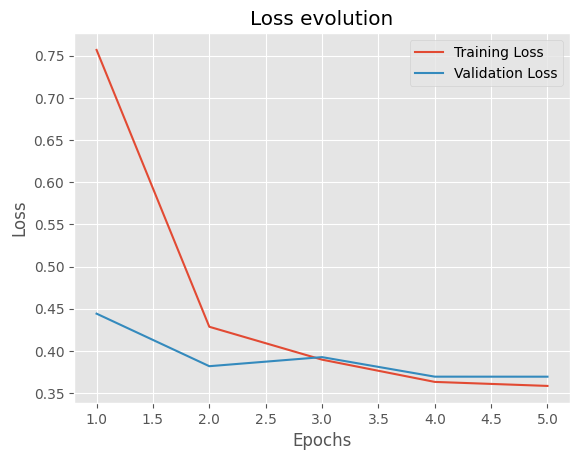

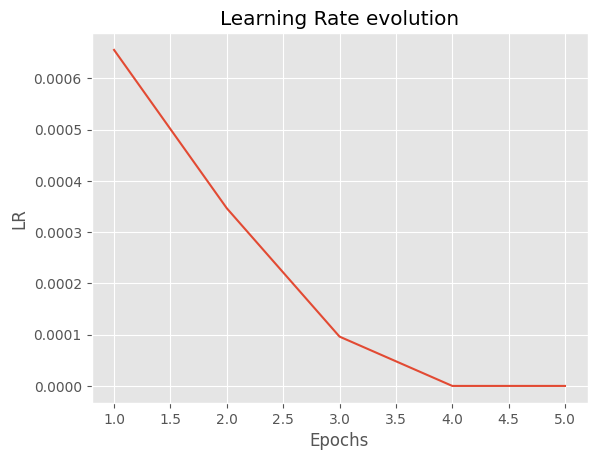

In [ ]:


BS = 64  # Replace with your actual batch size
EPOCHS = 10  # Replace with your actual number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Adjust accordingly

train_loader = DataLoader(
    train_ds,
    batch_size=BS,
    sampler=train_sampler,
    pin_memory=True,
    num_workers=1,
)
valid_loader = DataLoader(
    train_ds,
    batch_size=1,
    sampler=valid_sampler,
    pin_memory=True,
    num_workers=1,
)

for epoch in range(1, EPOCHS + 1):
    train_loss = 0.0
    n_tot_chunks = 0
    pbar = tqdm(train_loader, desc="Training", unit="batch")
    model.train()

    for step, (X_batch, y_batch) in enumerate(pbar):
        y_batch = y_batch.to(device, non_blocking=True)
        pred = torch.zeros_like(y_batch).to(device, non_blocking=True)
        optimizer.zero_grad()
        scheduler.step(step + train_size * epoch)
        h = None

        seq_len = X_batch.shape[1]
        for i in range(0, seq_len, max_chunk_size):
            X_chunk = X_batch[:, i : i + max_chunk_size].float()
            X_chunk = X_chunk.to(device, non_blocking=True)

            y_pred, h = model(X_chunk, h)
            h = [hi.detach() for hi in h]
            pred[:, i : i + max_chunk_size] = y_pred
            del X_chunk, y_pred

        loss = criterion(
            normalize(pred).float(),
            y_batch.float(),
        )
        loss.backward()
        train_loss += loss.item()
        n_tot_chunks += 1
        pbar.set_description(f'Training: loss = {(train_loss / n_tot_chunks):.2f}')

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1e-1)
        optimizer.step()
        del pred, loss, y_batch, X_batch, h
        gc.collect()

    train_loss /= len(train_loader)
    del pbar
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)

    if epoch % 1 == 0:
        valid_loss = evaluate(
            model, max_chunk_size, valid_loader, device, criterion
        )

        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(
                model.state_dict(),
                os.path.join(model_path, f"model_best.pth"),
            )

        dt = time.time() - dt
        print(
            f"{epoch}/{EPOCHS} -- ",
            f"train_loss = {train_loss:.6f} -- ",
            f"valid_loss = {valid_loss:.6f} -- ",
            f"time = {dt:.6f}s",
        )
        dt = time.time()

plot_history(history, model_path=model_path)
history_path = os.path.join(model_path, "history.json")
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=4)
